# LenslessPiCam Demo

In this notebook, we demonstrate different aspects of ``LenslessPiCam``. Check out the [documentation](https://lensless.readthedocs.io) and [GitHub](https://github.com/LCAV/LenslessPiCam) for more features!

Table of Contents:

1. [Datasets](#1.-Datasets)
2. [Characterizing the lensless camera](#2.-Characterizing-the-lensless-camera)
3. [PSF design](#3.-PSF-design-with-iterative-algorithm)
4. [Simulate PSFs](#simulate)
5. [Image recovery](#5.-Image-recovery)
6. [Shift-variant forward model](#6.-Shift-variant-forward-model)

You can also open the notebook in [Google Colab](https://colab.research.google.com/drive/1q56Ht647JD5wocnrcT7rH5TCNK7FKmtH?usp=sharing) and run it there.

[![Google colab demo](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1q56Ht647JD5wocnrcT7rH5TCNK7FKmtH?usp=sharing)

[Here](https://docs.google.com/presentation/d/1PcNhMfjATSwcpbHUMrmc88ciQmheBJ7alz8hel8xnGU/edit?pli=1#slide=id.p) are accompanying slides that were given at PhD course to introduce computational lensless imaging.

# 1. Datasets

LenslessPiCam provides a convenient interface to download multiple lensless datasets from Hugging Face.

In [1]:
from lensless.utils.dataset import print_available_datasets

print_available_datasets()

/Users/eric/anaconda3/envs/lensless/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Available datasets:
  - diffusercam_mirflickr (7.58 GB) : https://huggingface.co/datasets/bezzam/DiffuserCam-Lensless-Mirflickr-Dataset-NORM
  - tapecam_mirflickr (10.5 GB) : https://huggingface.co/datasets/bezzam/TapeCam-Mirflickr-25K
  - digicam_celeba (33.9 GB) : https://huggingface.co/datasets/bezzam/DigiCam-CelebA-26K
  - digicam_mirflickr (11.9 GB) : https://huggingface.co/datasets/bezzam/DigiCam-Mirflickr-SingleMask-25K
  - digicam_mirflickr_mini (0.472 GB) : https://huggingface.co/datasets/bezzam/DigiCam-Mirflickr-SingleMask-1K
  - digicam_mirflickr_multi (12 GB) : https://huggingface.co/datasets/bezzam/DigiCam-Mirflickr-MultiMask-25K
  - digicam_mirflickr_multi_mini (0.477 GB) : https://huggingface.co/datasets/bezzam/DigiCam-Mirflickr-MultiMask-25K
  - multilens_mirflickr_ambient (16.7 GB) : https://huggingface.co/datasets/Lensless/MultiLens-Mirflickr-Ambient
  - multilens_mirflickr_ambient_mini (0.0677 GB) : https://huggingface.co/datasets/Lensless/MultiLens-Mirflickr-Ambient

In [2]:
from lensless.utils.dataset import get_dataset

CACHE_DIR = None   # path to download dataset, by default it is stored in ~/.cache/huggingface/datasets
dataset = "diffusercam_mirflickr"
# dataset = "mls_mirflickr_1k"
# dataset = "fza_mirflickr_1k"

# load test set
test_set = get_dataset(
    dataset_name=dataset,
    split="test", 
    cache_dir=CACHE_DIR,
)
print(f"Number of files : {len(test_set)}")


Number of files : 999


# 2. Characterizing the lensless camera

We can characterize a lensless camera by analyzing its point spread function (PSF). The PSF is the image of a point source, and it is a measure of the camera's resolution. The PSF is also the impulse response of the camera, and it can be used to recover the original image from the camera's measurements.

The dataset loads the PSF as a PyTorch tensor, let's convert it to NumPy.

Number of files : 999
PSF shape : torch.Size([1, 135, 240, 3])
PSF range : [0.0 - 0.12337536364793777]


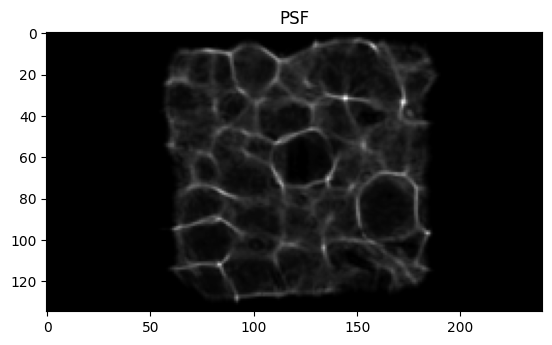

In [3]:
import matplotlib.pyplot as plt
from lensless.utils.plot import plot_image
from lensless.utils.dataset import get_dataset
from lensless.utils.io import save_image 
from lensless.utils.image import gamma_correction
import numpy as np

CACHE_DIR = None   # path to download dataset, by default it is stored in ~/.cache/huggingface/datasets
dataset = "diffusercam_mirflickr"
# dataset = "mls_mirflickr_1k"

gamma = 2

# load test set
test_set = get_dataset(
    dataset_name=dataset,
    split="test", 
    cache_dir=CACHE_DIR
)

print(f"Number of files : {len(test_set)}")
print(f"PSF shape : {test_set.psf.shape}")
print(f"PSF range : [{test_set.psf.min()} - {test_set.psf.max()}]")

psf = test_set.psf.numpy().squeeze()   # drop extra dimension for depth

# plot PSF
plot_image(psf, gamma=gamma)
plt.title("PSF");

# save PSF
psf_norm = psf.copy()
for i in range(psf.shape[2]):
    psf_norm[:, :, i] = psf_norm[:, :, i] / np.max(psf_norm[:, :, i])
    if gamma and gamma > 1:
        psf_norm[:, :, i] = gamma_correction(psf_norm[:, :, i], gamma=gamma)
save_image(psf_norm, f"psf.png")

Let's look at auto-correlation to see how well the PSF resolves features (narrower auto-correlation peak).

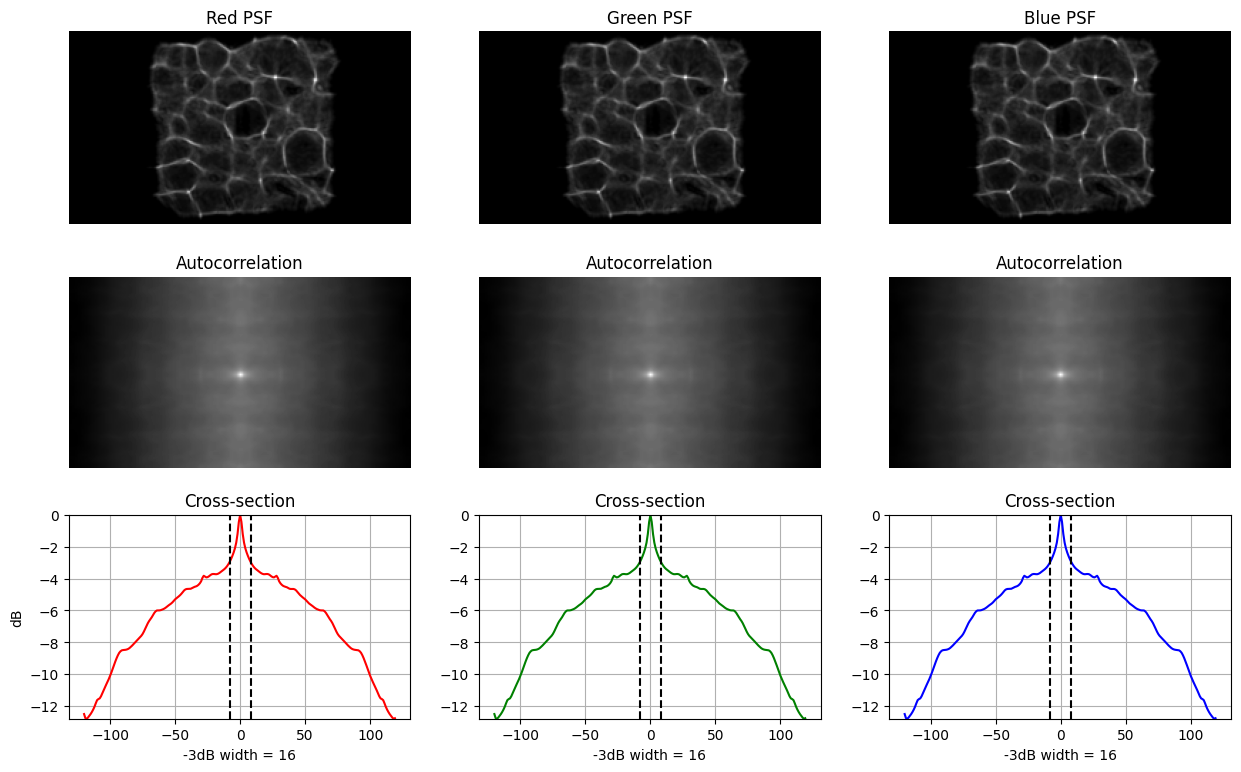

In [4]:
from lensless.utils.plot import plot_autocorr_rgb

plot_autocorr_rgb(psf, figsize=(15, 9), width=3, plot_psf=True);
plt.savefig("psf_autocorr.png")

Let's compare with another dataset that uses another mask.

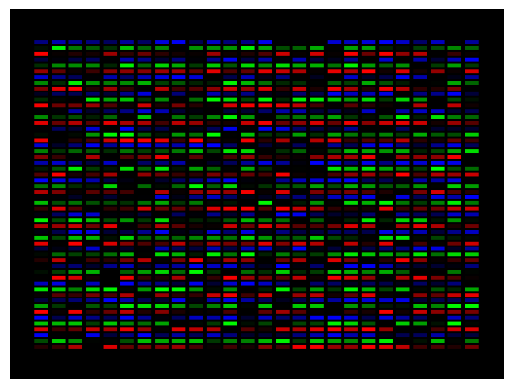

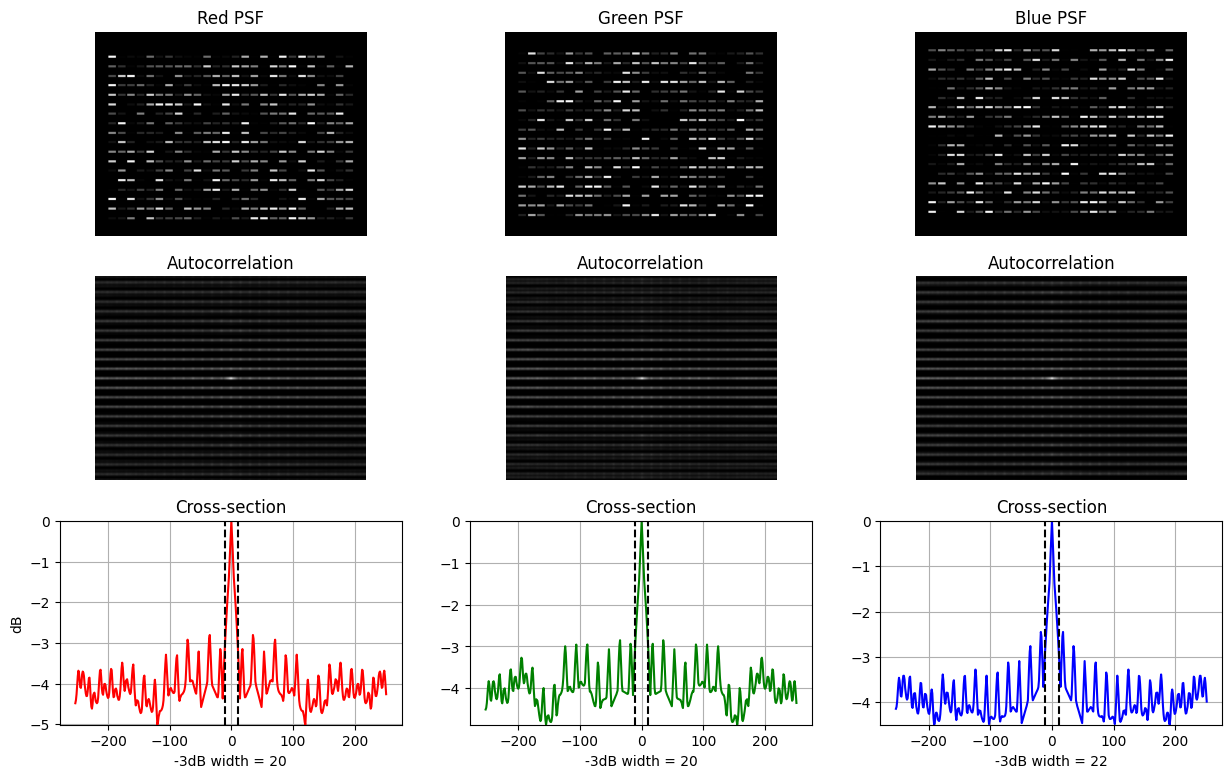

In [5]:
other_dataset = "multilens_mirflickr_ambient_mini"   # using multilens array (narrow autocorr)
other_dataset = "digicam_mirflickr_mini"             # using LCD as programmable mask (wide autocorr)
# other_dataset = "tapecam_mirflickr"                # using double-sided tape (medium autocorr)

# load other test set
other_test_set = get_dataset(
    dataset_name=other_dataset,
    split="test", 
    cache_dir=CACHE_DIR
)

# get PSF
other_psf = other_test_set.psf.numpy().squeeze()   # drop extra dimension for depth

# plot PSF
plot_image(other_psf, gamma=2)
# plt.title(f"PSF ({other_dataset})");
# remove axes labels
plt.axis('off')
plt.savefig("other_psf.png")

# plot auto-correlation
# plot_autocorr_rgb(other_psf, figsize=(15, 5), width=3);
plot_autocorr_rgb(other_psf, figsize=(15, 9), width=3, plot_psf=True, psf_gamma=1);
plt.savefig("psf_autocorr_other.png")

We can look at the Fourier transform of the PSF to see if there are dips that may amplify noise. Note that we use the real-valued FFT since the PSF is real-valued.

PSF mag shape : (135, 121, 3)
PSF mag range : 6.061037323437932e-06 - 1.0


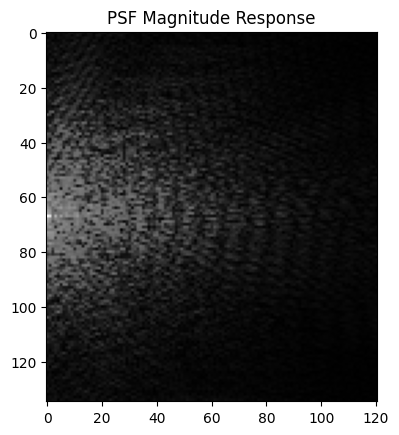

In [6]:
import numpy as np

# plot magnitude Fourier transform
psf_fft = np.fft.rfftn(psf, axes=[0, 1])
psf_fft = np.fft.fftshift(psf_fft, axes=[0])

psf_fft_mag = np.abs(psf_fft)
psf_fft_mag /= psf_fft_mag.max()

print(f"PSF mag shape : {psf_fft_mag.shape}")
print(f"PSF mag range : {psf_fft_mag.min()} - {psf_fft_mag.max()}")
plot_image(psf_fft_mag[:, :, 0], gamma=5)
plt.title("PSF Magnitude Response");

We can average over multiple cross-sections of the PSF to notice any sharp dips and the overall shape of the PSF (similar to Fig 7 of the [PhlatCam paper](https://www.researchgate.net/publication/340877837_PhlatCam_Designed_Phase-Mask_Based_Thin_Lensless_Camera)).

PSF mag range (dB) : -104.34891292015861 - 0.0


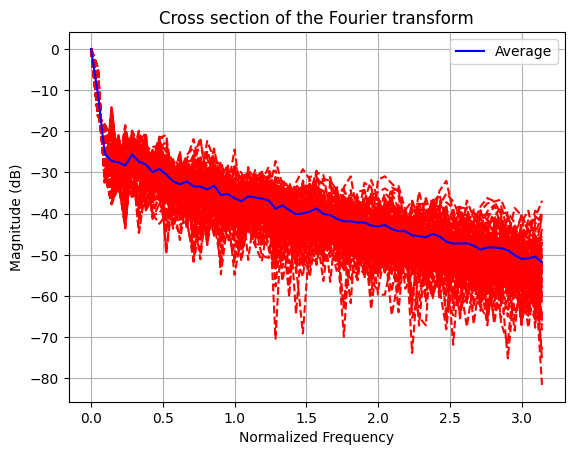

In [7]:
import scipy.ndimage

# in decibel
psf_fft_mag_db = 20 * np.log10(psf_fft_mag)
print(f"PSF mag range (dB) : {psf_fft_mag_db.min()} - {psf_fft_mag_db.max()}")

x0, y0 = psf_fft_mag_db.shape[0] // 2, 0
n_angles = 100
angles = np.linspace(0, np.pi, n_angles)

num = psf_fft_mag_db.shape[0] // 2
z = np.zeros((num, n_angles))
f_vals = np.linspace(0, np.pi, psf_fft_mag_db.shape[0] // 2)
for i, angle in enumerate(angles):
    x1 = x0 + np.cos(angle) * psf_fft_mag_db.shape[0] // 2
    y1 = y0 + np.sin(angle) * psf_fft_mag_db.shape[0] // 2
    if x1 < 0 or x1 >= psf_fft_mag_db.shape[0] or y1 < 0 or y1 >= psf_fft_mag_db.shape[1]:
        continue
    x, y = np.linspace(x0, x1, num), np.linspace(y0, y1, num)
    zi = scipy.ndimage.map_coordinates(psf_fft_mag_db[:, :, 0], np.vstack((x,y)))
    plt.plot(f_vals, zi, "r--")
    z[:, i] = zi

# plot average
plt.plot(f_vals, np.mean(z, axis=1), "b-", label="Average")
plt.legend()
plt.grid()
plt.title("Cross section of the Fourier transform")
plt.xlabel("Normalized Frequency")
plt.ylabel("Magnitude (dB)");


# 3. PSF design with iterative algorithm

Given a target PSF, we can design a mask that will produce a similar PSF. We can use an iterative algorithm to design the mask similar to the Gerchberg-Saxton algorithm. This idea was presented for lensless cameras in the [PhlatCam paper](https://www.researchgate.net/publication/340877837_PhlatCam_Designed_Phase-Mask_Based_Thin_Lensless_Camera).

Below we try to design a mask that will produce a PSF similar to the one we loaded above (DiffuserCam).

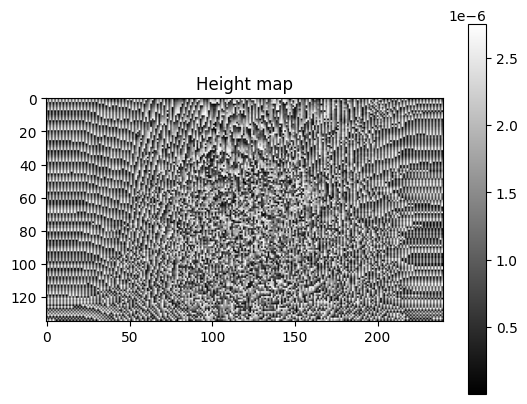

In [8]:
from lensless.hardware.mask import phase_retrieval

wv_green = 550e-9
psf_green = psf[:, :, 1]
mask_size = 4e-3
N = 1024
dz = 2e-3  # propagation distance
n_iter = 100

d1 = mask_size / N
phase, height_map = phase_retrieval(
    target_psf=psf_green,
    wv=wv_green,
    d1=d1,
    dz=dz,
    height_map=True,
    n_iter = n_iter,
)
plt.imshow(height_map, cmap="gray")
# color bar
cbar = plt.colorbar()
plt.title("Height map");

Let's compare the PSF of the designed mask with the target PSF.

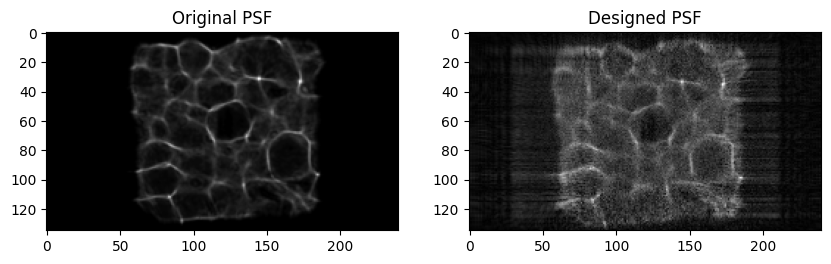

In [9]:
from waveprop.fresnel import fresnel_conv

psf_designed, x, y = fresnel_conv(
    u_in=np.exp(1j * phase), 
    wv=wv_green, 
    d1=d1, 
    dz=dz
)

# compare
_, ax = plt.subplots(ncols=2, figsize=(10, 5))
plot_image(psf_green, ax=ax[0], gamma=2)
ax[0].set_title("Original PSF")
plot_image(np.abs(psf_designed), ax=ax[1])
ax[1].set_title("Designed PSF");


<a id='simulate'></a>
# 4. Simulate PSFs (TODO)

In the above design we used free-space propagation (Fresnel diffraction) in the iterative design (forward and backward propagation). 

Similarly, given a mask structure, we can simulate the corresponding PSF using free-space propagation.

In [10]:
"""
TODO: but essentially what's done with the programmable mask used in DigiCam
# https://github.com/LCAV/LenslessPiCam/blob/99d63419a34a57f79def45333e20d0e0d3ab2577/lensless/hardware/slm.py#L364

1. Spherical wavefront from point source at desired distance to the mask
2. Multiplication with mask function
3. Free-space propagation to the sensor

"""

"\nTODO: but essentially what's done with the programmable mask used in DigiCam\n# https://github.com/LCAV/LenslessPiCam/blob/99d63419a34a57f79def45333e20d0e0d3ab2577/lensless/hardware/slm.py#L364\n\n1. Spherical wavefront from point source at desired distance to the mask\n2. Multiplication with mask function\n3. Free-space propagation to the sensor\n\n"

# 5. Image recovery

In this section, we show different reconstruction approaches.

First we perfrom the adjoint test, which is a sanity check to see if the forward and backward operators are consistent.

## Adjoint test

To check that the forward and backward operators are adjoint, we can use the following test:

$$
\langle A x, y \rangle = \langle x, A^H y \rangle
$$

where $A$ is the forward operator, $A^H$ is the backward operator, and $\langle \cdot, \cdot \rangle$ is the dot product.

For lensless imaging, our forward operator is convolution with the PSF and our backward operator is convolution with the conjugate PSF.

In [4]:
import numpy as np
from lensless.recon.rfft_convolve import RealFFTConvolve2D

psf_numpy = test_set.psf.numpy()

# create the convolution object
convolver = RealFFTConvolve2D(psf=psf_numpy)

x_rand = np.random.randn(*psf_numpy.shape)
y_rand = np.random.randn(*psf_numpy.shape)

# adjoint test
lhs = np.dot(convolver.convolve(x_rand).flatten(), y_rand.flatten())
rhs = np.dot(x_rand.flatten(), convolver.deconvolve(y_rand).flatten())
if np.allclose(lhs, rhs):
    print("Adjoint test passed!")
else:
    print(f"Adjoint test failed: {lhs} != {rhs}")


Adjoint test passed!


# Select dataset

Let's pick a dataset from the options defined above.

In [12]:
from lensless.utils.dataset import print_available_datasets

print_available_datasets()

Available datasets:
  - diffusercam_mirflickr (7.58 GB) : https://huggingface.co/datasets/bezzam/DiffuserCam-Lensless-Mirflickr-Dataset-NORM
  - tapecam_mirflickr (10.5 GB) : https://huggingface.co/datasets/bezzam/TapeCam-Mirflickr-25K
  - digicam_celeba (33.9 GB) : https://huggingface.co/datasets/bezzam/DigiCam-CelebA-26K
  - digicam_mirflickr (11.9 GB) : https://huggingface.co/datasets/bezzam/DigiCam-Mirflickr-SingleMask-25K
  - digicam_mirflickr_mini (0.472 GB) : https://huggingface.co/datasets/bezzam/DigiCam-Mirflickr-SingleMask-25K
  - digicam_mirflickr_multi (12 GB) : https://huggingface.co/datasets/bezzam/DigiCam-Mirflickr-MultiMask-25K
  - digicam_mirflickr_multi_mini (0.477 GB) : https://huggingface.co/datasets/bezzam/DigiCam-Mirflickr-MultiMask-25K
  - multilens_mirflickr_ambient (16.7 GB) : https://huggingface.co/datasets/Lensless/MultiLens-Mirflickr-Ambient
  - multilens_mirflickr_ambient_mini (0.0677 GB) : https://huggingface.co/datasets/Lensless/MultiLens-Mirflickr-Ambien

Number of files : 999


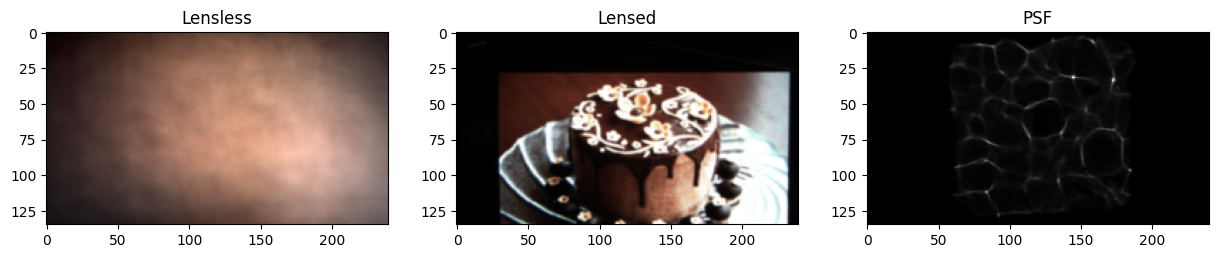

In [6]:
from lensless.utils.dataset import get_dataset


CACHE_DIR = None   # path to download dataset, by default it is stored in ~/.cache/huggingface/datasets
dataset = "diffusercam_mirflickr"
idx = 1

# dataset = "digicam_mirflickr_mini"
# dataset= "tapecam_mirflickr"
# dataset = "voronoi_mirflickr_mini"
# idx = 2

# load test set
test_set = get_dataset(
    dataset_name=dataset,
    split="test", 
    cache_dir=CACHE_DIR
)
print(f"Number of files : {len(test_set)}")
lensless, lensed = test_set[idx]
psf = test_set.psf.numpy().squeeze()   # drop extra dimension for depth

fig, axs = plt.subplots(1, 3, figsize=(15, 15))
plot_image(lensless, ax=axs[0])
axs[0].set_title("Lensless")
plot_image(lensed, ax=axs[1])
axs[1].set_title("Lensed")
plot_image(psf, ax=axs[2])
axs[2].set_title("PSF");

# Direct Inversion

For a linear system $y = Ax$, direct inversion corresponds to:
$$
\hat{x} = A^{-1} y.
$$

This generally cannot be done for lensless imaging, as $A$ may not be a square matrix. Instead we could apply the pseudoinverse $A^+ = (A^H A)^{-1} A^H$.
$$
\hat{x} = A^+y.
$$

The pseudoinverse is essentially the normalized adjoint! So we can apply our deconvolve method. Internally, we perform operations in the frequency domain, exploiting the convolution theorem and FFTs, to compute the estimate more efficiently.

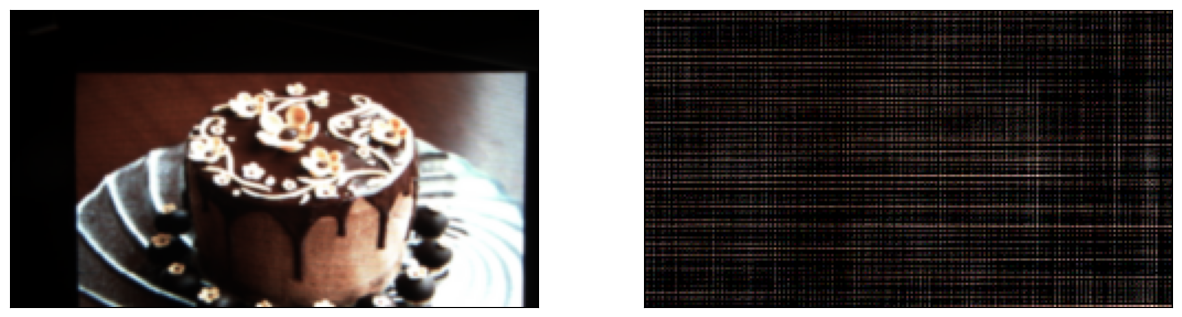

In [ ]:
import numpy as np
from lensless.recon.rfft_convolve import RealFFTConvolve2D
from lensless.utils.io import save_image 


def direct_inversion(psf):

    convolver = RealFFTConvolve2D(psf=psf)

    # set deconvoler PSF to that of Wiener filter
    convolver._Hadj = 1 / convolver._H.conj()
    # convolver._Hadj = convolver._H.conj() / (np.abs(convolver._H) ** 2) # similar to pseudoinverse

    # apply Wiener filter
    wiener_out = convolver.deconvolve(lensless)

    return wiener_out

fig, axs = plt.subplots(1, 2, figsize=(15, 15))
plot_image(lensed, ax=axs[0])
# axs[0].set_title("Lensed")
axs[0].set_xticks([])
axs[0].set_yticks([])
direct_inv = direct_inversion(test_set.psf)

# -- clamp
direct_inv = np.clip(direct_inv, 0, direct_inv.max())
plot_image(direct_inv, ax=axs[1])
# axs[1].set_title("Direct inversion")
axs[1].set_xticks([])
axs[1].set_yticks([])

## SAVE
save_image(lensed.numpy(), "lensed.png")
save_image(direct_inv.numpy(), "direct_inv.png")


## Wiener filtering (closed form)

Here we apply Wiener filtering by taking using the same ``RealFFTConvolve2D`` operator as above, but we change the adjoint operator with the Wiener filter.

$$
G = \frac{H^*}{|H|^2 + K}
$$

where $H$ is the PSF, $K$ is the regularization parameter, and $G$ is the Wiener filter.

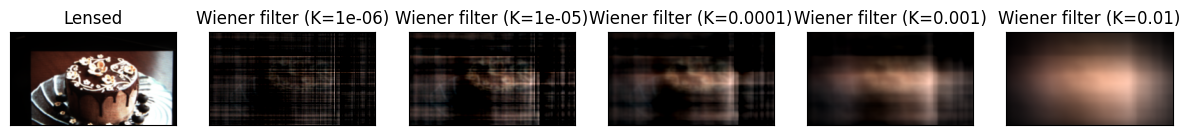

In [8]:
from lensless.recon.rfft_convolve import RealFFTConvolve2D

# TODO could be improved by using the spectrum decay of the PSF?
def wiener_filter(psf, K):

    convolver = RealFFTConvolve2D(psf=psf)

    # import torch
    # noise_est = torch.mean(torch.abs(convolver._H), dim=(0, 1, 2)).unsqueeze(0).unsqueeze(0).unsqueeze(0)
    # R = np.abs(convolver._H) / noise_est
    # convolver._Hadj = convolver._H.conj() / (np.abs(convolver._H) ** 2 + R)
    
    # set deconvoler PSF to that of Wiener filter
    convolver._Hadj = convolver._H.conj() / (np.abs(convolver._H) ** 2 + K)

    # apply Wiener filter
    wiener_out = convolver.deconvolve(lensless)

    return wiener_out

# try different values of K
K_vals = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
# K_vals = [1e-5]

fig, axs = plt.subplots(1, len(K_vals)+1, figsize=(15, 15))
plot_image(lensed, ax=axs[0])
axs[0].set_title("Lensed")
axs[0].set_xticks([])
axs[0].set_yticks([])
for i, K in enumerate(K_vals):
    wiener_out = wiener_filter(test_set.psf, K)
    # -- clamp
    wiener_out = np.clip(wiener_out, 0, wiener_out.max())
    
    # plot
    plot_image(wiener_out, ax=axs[i+1])
    axs[i+1].set_title(f"Wiener filter (K={K})")

    # turn off axis labels
    axs[i+1].set_xticks([])
    axs[i+1].set_yticks([])

    # save
    save_image(wiener_out.numpy(), f"wiener_{K}.png")
    

# FISTA

Here we apply gradient descent with a non-negative proximal operator to recover the image. We compare normal gradient descent with the [FISTA update](https://www.ceremade.dauphine.fr/~carlier/FISTA) (but not soft-thresholding).

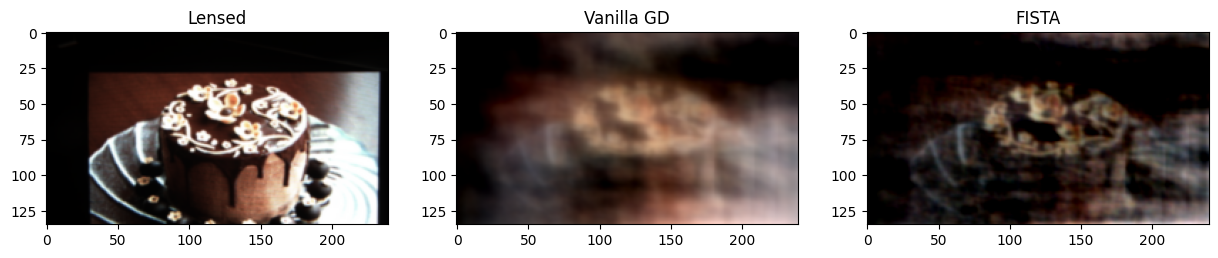

In [ ]:
from lensless import GradientDescent, FISTA
from lensless.utils.io import save_image 

max_iter = 100

# normal gradient descent
recon = GradientDescent(test_set.psf, n_iter=max_iter)
recon.set_data(lensless)
vanilla_gd = recon.apply()
save_image(vanilla_gd.numpy(), f"gradient_descent_{max_iter}.png")

# FISTA
recon = FISTA(test_set.psf, n_iter=max_iter)
recon.set_data(lensless)
fista_gd = recon.apply()
save_image(fista_gd.numpy(), f"fista_{max_iter}.png")

# compare
fig, axs = plt.subplots(1, 3, figsize=(15, 15))
plot_image(lensed, ax=axs[0])
axs[0].set_title("Lensed")
plot_image(vanilla_gd, ax=axs[1])
axs[1].set_title("Vanilla GD")
plot_image(fista_gd, ax=axs[2])
axs[2].set_title("FISTA");


# ADMM

Here we apply the [Alternating Direction Method of Multipliers](https://web.stanford.edu/~boyd/papers/pdf/admm_distr_stats.pdf) to recover the image. We add a non-negative constraint and a TV regularization term.

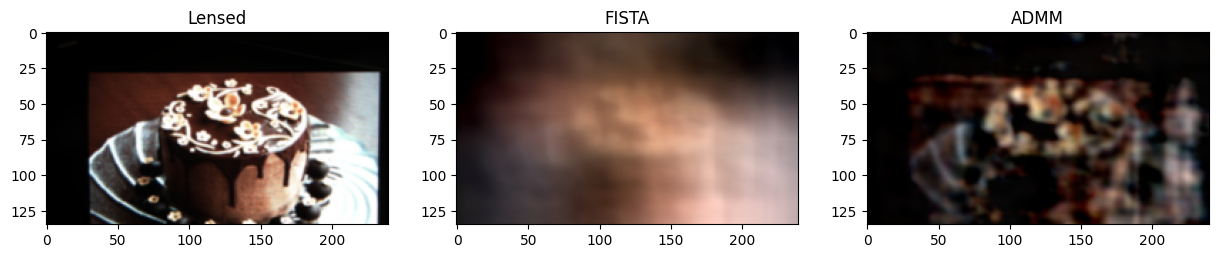

In [12]:
from lensless import ADMM

max_iter = 10

# FISTA
recon = FISTA(test_set.psf, n_iter=max_iter)
recon.set_data(lensless)
fista_gd = recon.apply()
save_image(fista_gd.numpy(), f"fista_{max_iter}.png")

# ADMM
recon = ADMM(test_set.psf, n_iter=max_iter)
recon.set_data(lensless)
admm_out = recon.apply()
save_image(admm_out.numpy(), f"admm_{max_iter}.png")

# compare
fig, axs = plt.subplots(1, 3, figsize=(15, 15))
plot_image(lensed, ax=axs[0])
axs[0].set_title("Lensed")
plot_image(fista_gd, ax=axs[1])
axs[1].set_title("FISTA")
plot_image(admm_out, ax=axs[2])
axs[2].set_title("ADMM");

# Learned reconstruction

Now we unrolled the ADMM algorithm and learn its parameters along with two neural networks: one before and one after the ADMM iterations.

Such models can be trained with the above datasets, using [this script](https://github.com/LCAV/LenslessPiCam/blob/main/scripts/recon/train_learning_based.py), with the default configuration [here](https://github.com/LCAV/LenslessPiCam/blob/main/configs/train_unrolledADMM.yaml).

In [17]:
from lensless.recon.model_dict import load_model, download_model
import torch

CAMERA = "diffusercam"
DATASET = "mirflickr"
model_key = "Unet4M+U10+Unet4M"
device = "cuda:0"

# load model
model_path = download_model(camera=CAMERA, dataset=DATASET, model=model_key)
model = load_model(model_path, psf=test_set.psf.to(device), device=device, legacy_denoiser=False)

Loading checkpoint from :  /root/LenslessPiCam/lensless/recon/../../models/diffusercam/mirflickr/Unet4M+U10+Unet4M/recon_epochBEST


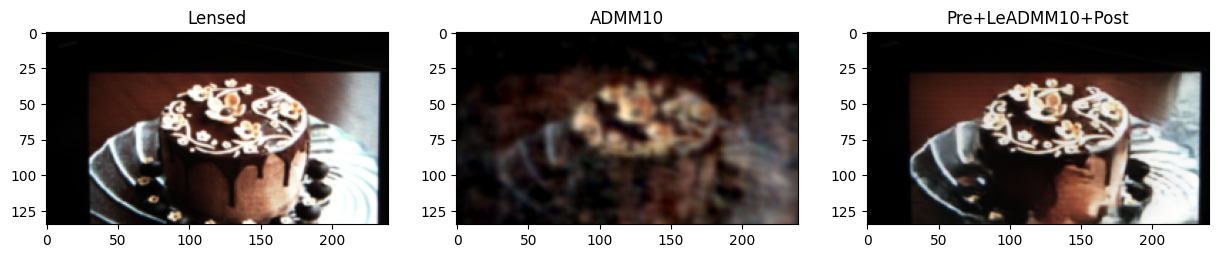

In [18]:
# apply
model.set_data(lensless.to(device))
with torch.no_grad():
    learned_out = model.apply(plot=False)[0].cpu()

# compare
fig, axs = plt.subplots(1, 3, figsize=(15, 15))
plot_image(lensed, ax=axs[0])
axs[0].set_title("Lensed")
plot_image(admm_out, ax=axs[1])
axs[1].set_title("ADMM10")
plot_image(learned_out, ax=axs[2])
axs[2].set_title("Pre+LeADMM10+Post");

# 6. Shift-variant forward model

Lensless imaging typically assumes a shift-invariant convolution model. However, in practice, the convolution is shift-variant. We can model the forward model as shift-variant with multiple PSFs.

In [PhoCoLens](https://phocolens.github.io/), they divide the image space into a (KxK) grid and learn a PSF for each off-axis point.

Number of files : 999
PSF shape : torch.Size([1, 135, 240, 3])
PSF range : [0.0 - 0.12337537109851837]
PSF shape : (135, 240, 3)
[(22, 40), (22, 120), (22, 200), (67, 40), (67, 120), (67, 200), (112, 40), (112, 120), (112, 200)]


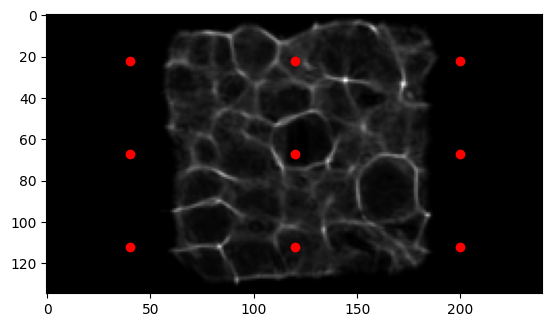

In [ ]:
import matplotlib.pyplot as plt
from lensless.utils.plot import plot_image
from lensless.utils.dataset import get_dataset

CACHE_DIR = None   # path to download dataset, by default it is stored in ~/.cache/huggingface/datasets
dataset = "diffusercam_mirflickr"

# load test set
test_set = get_dataset(
    dataset_name=dataset,
    split="test", 
    cache_dir=CACHE_DIR
)
print(f"PSF shape : {test_set.psf.shape}")
print(f"PSF range : [{test_set.psf.min()} - {test_set.psf.max()}]")

psf = test_set.psf.numpy().squeeze()   # drop extra dimension for depth

# get centers of KxK patches
K = 3
Nx, Ny = psf.shape[:2]
centers = []
for i in range(K):
    for j in range(K):
        centers.append((int((i+0.5)*Nx/K), int((j+0.5)*Ny/K)))
print("centers : ", centers)

# plot centers as red dots
ax = plot_image(psf, gamma=2)
for center in centers:
    ax.plot(center[1], center[0], 'ro')

Eq. 6 of [the paper](https://arxiv.org/pdf/2409.17996) proposes a set of filters to bias learnable filters to learn the best PSF for each point.

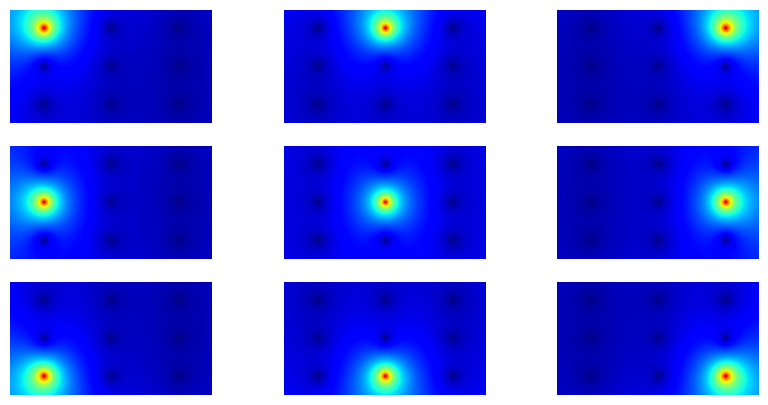

In [11]:
from lensless import SVDeconvNet

recon = SVDeconvNet(test_set.psf, K=K)
weight_mat = recon.weight_mat.numpy().squeeze()

# plot array of weight matrices
cmap = "jet"   # "gray"
fig, ax = plt.subplots(K, K, figsize=(10, 5))
for i in range(K):
    for j in range(K):
        ax[i, j].imshow(weight_mat[i*K+j], cmap=cmap)
        ax[i, j].axis('off')